## Long short-term memory autoencoder

*Autoencoder* — архитектура нейронной сети, которая по входным данным получает выходные данные той же размерности. В зависимости от типа может иметь один или несколько скрытых слоев. Автоенкодеры имеют два модуля: кодировщик (encoder) и декодировщик (decoder). Кодировщик работает со здоровыми данными и изучает как устроены нормальные рабочие процессы системы, а затем сжимает данные в скрытое представление. Декодировщик пытается восстановить из этого представления выходные данные. Все что на выходе не соответсвует нормальному состоянию системы будет определено как аномалия. **Цель** — получить на выходном слое отклик, наиболее близкий к входному.

<img src="./img/ae_scheme.png" alt="Drawing" style="width: 600px; height: 350px"/>

В скрытых слоях используется реккурентный слой LSTM. В отличие от обычного реккурентного слоя, слой LSTM дополнительную имеет память и устроен более хитро, но благодаря этому может запоминать больший контекст входной последовательности.


<img src="./img/lstm_cell.png" alt="Drawing" style="width: 600px; height: 230px"/>

Помимо обычного входа и выхода, LSTM слой имеет прямую состояния, которая отвечает за запоминание и располагается вдоль всего слоя. На рисунке это верхняя горизонтальная прямая. Чтобы добавить, удалить или получить информацию из состояния существуют gates (гейты). 

1. Первый гейт отвечает за то, какую информацию нужно выбросить из состояния, он называется forget gate (гейт забывания). Решение принимается с помощью сигмоиды, область значений которой определена на интервале $[0, 1]$. Значение $0$ говорит о том, что вообще не нужно пропускать информацию дальше, значение $1$  пропускает информацию полностью.


2. Следующий шаг заключается в том, какую новую информацию необходимо сохранить в состояние, это input gate (входной гейт). Здесь есть три этапа. На первом через сигмоиду решается, какие значения в состоянии нужно обновить. На втором с помощью гиперболического тангенса (область значений которого интервал $[-1, 1]$), определяется "направление сохранения", т.е. на сколько нужно уменьшить или увеличить значение в состоянии. Третий этап это поэлементное умножение векторов (результирующий эффект обновления и направления) из предыдущих двух этапов и поэлементное сложение с вектором состояния, полученного из предыдущего гейта. 

После этого шага вектор состояния больше меняться не будет, в полученном виде он пойдет на следующую итерацию.

3. Осталось решить, что пойдет на выход, и за это отвечает третий гейт, который называется output gate (выходной гейт). На этом шаге сигмоида решает, что из вектора состояния, пропущенного через гиперболический тангенс, пойдет на выход. Можно провести аналогию со вторым шагом, только теперь тангенс является фильтром для вектора состояния, его контекст, накопленный в процессе обучения, помогает скорректировать выход на следующую итерацию.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE

### Seed fixation

In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

### Process data

In [3]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


### Make predictor

In [4]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [5]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AE_Predictor(Predictor):
    def make_prediction(self, df):
        first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
        df = df.drop(['anomaly','changepoint'], axis=1)
        conf.train_size = first_anomaly_idx
        ss = StandardScaler()
        
        x_train = np.array(ss.fit_transform(df[:conf.train_size]))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_AE(optimizer=optimizer, loss='mae')
        model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)

        x_test = np.array(ss.transform(df))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))  
        health_r = r[:conf.train_size]
        
        # UCL = health_r.quantile(conf.Q)
        # Чтобы "выбросы" не испортили предсказания, убираем срабатывания на пересечении
        UCL = health_r[: len(health_r) - conf.TIME_STEPS + 1].quantile(conf.Q)
        
        anomalous_data = r > UCL
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS, len(x_test) - conf.TIME_STEPS + 1):
#             if np.all(anomalous_data[data_idx - conf.TIME_STEPS : data_idx]):
#                 anomalous_data_indices.append(data_idx - conf.TIME_STEPS)

            # Чуть более слабое условие для того чтобы по окну определить аномалию
            # Повышая порог можно увеличить мар и уменьшить фар
            if (anomalous_data[data_idx - conf.TIME_STEPS : data_idx]).astype(int).sum() >= conf.TIME_STEPS * 0.8:
                anomalous_data_indices.append(data_idx - conf.TIME_STEPS)
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

In [6]:
prediction = LSTM_AE_Predictor().make_prediction(df)

Epoch 1/10
53/53 [==============================] - 13s 149ms/step - loss: 0.7618
Epoch 2/10
53/53 [==============================] - 7s 132ms/step - loss: 0.6833
Epoch 3/10
53/53 [==============================] - 7s 129ms/step - loss: 0.6280
Epoch 4/10
53/53 [==============================] - 7s 125ms/step - loss: 0.6061
Epoch 5/10
53/53 [==============================] - 7s 131ms/step - loss: 0.5936
Epoch 6/10
53/53 [==============================] - 7s 127ms/step - loss: 0.5872
Epoch 7/10
53/53 [==============================] - 8s 147ms/step - loss: 0.5826
Epoch 8/10
53/53 [==============================] - 7s 137ms/step - loss: 0.5776
Epoch 9/10
53/53 [==============================] - 7s 135ms/step - loss: 0.5760
Epoch 10/10
53/53 [==============================] - 7s 131ms/step - loss: 0.5703


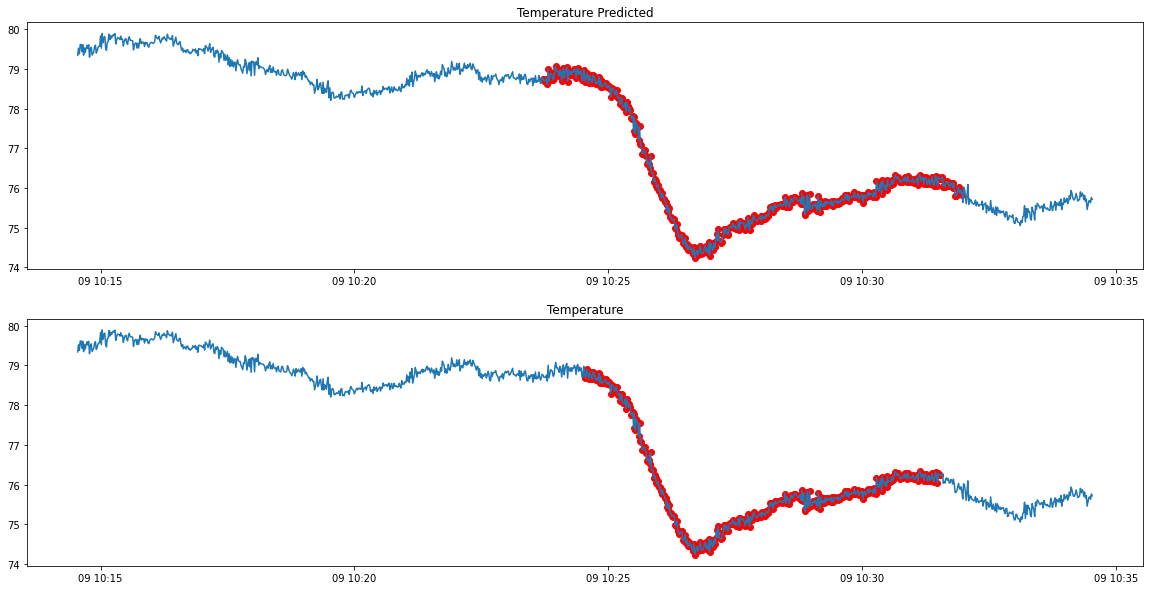

In [7]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [8]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.9165714285714286
FAR = 0.09785522788203753
MAR = 0.0


### Применение метода ко всем датасетам

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 14s 148ms/step - loss: 0.8948
Epoch 2/10
53/53 [==============================] - 7s 130ms/step - loss: 0.6814
Epoch 3/10
53/53 [==============================] - 7s 141ms/step - loss: 0.6413
Epoch 4/10
53/53 [==============================] - 6s 120ms/step - loss: 0.6156
Epoch 5/10
53/53 [==============================] - 7s 132ms/step - loss: 0.6022
Epoch 6/10
53/53 [==============================] - 7s 134ms/step - loss: 0.5945
Epoch 7/10
53/53 [==============================] - 6s 117ms/step - loss: 0.5894
Epoch 8/10
53/53 [==============================] - 7s 131ms/step - loss: 0.5855
Epoch 9/10
53/53 [==============================] - 7s 134ms/step - loss: 0.5835
Epoch 10/10
53/53 [==============================] - 7s 131ms/step - loss: 0.5795
Epoch 1/10
53/53 [==============================] - 12s 118ms/step - loss: 0.6896
Epoch 2/10
53/53 [==============================] - 6s 114ms/step - loss: 0.6177
Epoch 3/10
53/53 [=======

IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 12s 119ms/step - loss: 0.7245
Epoch 2/10
52/52 [==============================] - 6s 118ms/step - loss: 0.6681
Epoch 3/10
52/52 [==============================] - 6s 118ms/step - loss: 0.6536
Epoch 4/10
52/52 [==============================] - 6s 122ms/step - loss: 0.6461
Epoch 5/10
52/52 [==============================] - 6s 120ms/step - loss: 0.6383
Epoch 6/10
52/52 [==============================] - 7s 130ms/step - loss: 0.6352
Epoch 7/10
52/52 [==============================] - 8s 150ms/step - loss: 0.6261
Epoch 8/10
52/52 [==============================] - 7s 127ms/step - loss: 0.6222
Epoch 9/10
52/52 [==============================] - 6s 115ms/step - loss: 0.6149
Epoch 10/10
52/52 [==============================] - 6s 116ms/step - loss: 0.6103
Epoch 1/10
52/52 [==============================] - 11s 113ms/step - loss: 58967188.0000
Epoch 2/10
52/52 [==============================] - 6s 114ms/step - loss: 195796960.0000
Epoch 3/10

IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
51/51 [==============================] - 13s 133ms/step - loss: 0.7443
Epoch 2/10
51/51 [==============================] - 6s 116ms/step - loss: 0.6631
Epoch 3/10
51/51 [==============================] - 6s 117ms/step - loss: 0.6280
Epoch 4/10
51/51 [==============================] - 6s 118ms/step - loss: 0.6188
Epoch 5/10
51/51 [==============================] - 7s 133ms/step - loss: 0.6132
Epoch 6/10
51/51 [==============================] - 6s 125ms/step - loss: 0.6112
Epoch 7/10
51/51 [==============================] - 6s 117ms/step - loss: 0.6070
Epoch 8/10
51/51 [==============================] - 6s 116ms/step - loss: 0.6020
Epoch 9/10
51/51 [==============================] - 6s 115ms/step - loss: 0.5968
Epoch 10/10
51/51 [==============================] - 6s 119ms/step - loss: 0.5929
F1 = 0.28776978417266186

FAR = 0.08976660682226212

MAR = 0.7872340425531915

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 10s 111ms/step - loss: 0.7396
Epoch 2/10
53/53 [==============================] - 6s 112ms/step - loss: 0.6941
Epoch 3/10
53/53 [==============================] - 6s 117ms/step - loss: 0.6758
Epoch 4/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6695
Epoch 5/10
53/53 [==============================] - 6s 119ms/step - loss: 0.6543
Epoch 6/10
53/53 [==============================] - 6s 119ms/step - loss: 0.6440
Epoch 7/10
53/53 [==============================] - 7s 135ms/step - loss: 0.6388
Epoch 8/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6344
Epoch 9/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6282
Epoch 10/10
53/53 [==============================] - 6s 118ms/step - loss: 0.6224
F1 = 0.9398556535685646

FAR = 0.10121457489878542

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 129ms/step - loss: 0.7230
Epoch 2/10
53/53 [==============================] - 7s 131ms/step - loss: 0.6735
Epoch 3/10
53/53 [==============================] - 7s 127ms/step - loss: 0.6603
Epoch 4/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6512
Epoch 5/10
53/53 [==============================] - 6s 117ms/step - loss: 0.6470
Epoch 6/10
53/53 [==============================] - 6s 116ms/step - loss: 0.6635
Epoch 7/10
53/53 [==============================] - 6s 121ms/step - loss: 0.6483
Epoch 8/10
53/53 [==============================] - 7s 131ms/step - loss: 0.6434
Epoch 9/10
53/53 [==============================] - 6s 119ms/step - loss: 0.6408
Epoch 10/10
53/53 [==============================] - 6s 119ms/step - loss: 0.6373
F1 = 0.9260780287474333

FAR = 0.09742895805142084

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 11s 118ms/step - loss: 0.7859
Epoch 2/10
52/52 [==============================] - 6s 114ms/step - loss: 0.6869
Epoch 3/10
52/52 [==============================] - 6s 115ms/step - loss: 0.6481
Epoch 4/10
52/52 [==============================] - 6s 115ms/step - loss: 0.6261
Epoch 5/10
52/52 [==============================] - 6s 116ms/step - loss: 0.6174
Epoch 6/10
52/52 [==============================] - 6s 116ms/step - loss: 0.6099
Epoch 7/10
52/52 [==============================] - 6s 118ms/step - loss: 0.6059
Epoch 8/10
52/52 [==============================] - 6s 116ms/step - loss: 0.6010
Epoch 9/10
52/52 [==============================] - 6s 117ms/step - loss: 0.5974
Epoch 10/10
52/52 [==============================] - 6s 116ms/step - loss: 0.6005
F1 = 0.8904899135446686

FAR = 0.10284167794316644

MAR = 0.0

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
45/45 [==============================] - 10s 115ms/step - loss: 0.7041
Epoch 2/10
45/45 [==============================] - 5s 115ms/step - loss: 0.5807
Epoch 3/10
45/45 [==============================] - 5s 115ms/step - loss: 0.5574
Epoch 4/10
45/45 [==============================] - 5s 115ms/step - loss: 0.5402
Epoch 5/10
45/45 [==============================] - 6s 132ms/step - loss: 0.5254
Epoch 6/10
45/45 [==============================] - 6s 130ms/step - loss: 0.5145
Epoch 7/10
45/45 [==============================] - 6s 129ms/step - loss: 0.5061
Epoch 8/10
45/45 [==============================] - 6s 123ms/step - loss: 0.4964
Epoch 9/10
45/45 [==============================] - 5s 118ms/step - loss: 0.4967
Epoch 10/10
45/45 [==============================] - 5s 117ms/step - loss: 0.4930
F1 = 0.6843267108167771

FAR = 0.05015197568389058

MAR = 0.41509433962264153

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 114ms/step - loss: 84290704.0000
Epoch 2/10
53/53 [==============================] - 6s 114ms/step - loss: 8457870336.0000
Epoch 3/10
53/53 [==============================] - 6s 116ms/step - loss: 384118048.0000
Epoch 4/10
53/53 [==============================] - 6s 115ms/step - loss: 249758128.0000
Epoch 5/10
53/53 [==============================] - 6s 118ms/step - loss: 178001552.0000
Epoch 6/10
53/53 [==============================] - 6s 116ms/step - loss: 135860880.0000
Epoch 7/10
53/53 [==============================] - 6s 117ms/step - loss: 102875888.0000
Epoch 8/10
53/53 [==============================] - 6s 118ms/step - loss: 114606552.0000
Epoch 9/10
53/53 [==============================] - 6s 116ms/step - loss: 69361472.0000
Epoch 10/10
53/53 [==============================] - 6s 116ms/step - loss: 63907276.0000
F1 = 0.7607361963190185

FAR = 0.001658374792703151

MAR = 0.3841059602649007

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
6/6 [==============================] - 6s 115ms/step - loss: 0.7915
Epoch 2/10
6/6 [==============================] - 1s 111ms/step - loss: 0.7852
Epoch 3/10
6/6 [==============================] - 1s 113ms/step - loss: 0.7643
Epoch 4/10
6/6 [==============================] - 1s 111ms/step - loss: 0.7475
Epoch 5/10
6/6 [==============================] - 1s 110ms/step - loss: 0.7467
Epoch 6/10
6/6 [==============================] - 1s 113ms/step - loss: 0.7383
Epoch 7/10
6/6 [==============================] - 1s 112ms/step - loss: 0.7345
Epoch 8/10
6/6 [==============================] - 1s 111ms/step - loss: 0.7324
Epoch 9/10
6/6 [==============================] - 1s 113ms/step - loss: 0.7295
Epoch 10/10
6/6 [==============================] - 1s 112ms/step - loss: 0.7263
F1 = 0.7909371781668383

FAR = 0.5126262626262627

MAR = 0.0

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 11s 113ms/step - loss: 1.2686
Epoch 2/10
52/52 [==============================] - 6s 114ms/step - loss: 0.6937
Epoch 3/10
52/52 [==============================] - 6s 113ms/step - loss: 0.6733
Epoch 4/10
52/52 [==============================] - 7s 132ms/step - loss: 0.6645
Epoch 5/10
52/52 [==============================] - 7s 134ms/step - loss: 0.6588
Epoch 6/10
52/52 [==============================] - 6s 123ms/step - loss: 0.6536
Epoch 7/10
52/52 [==============================] - 6s 117ms/step - loss: 0.6496
Epoch 8/10
52/52 [==============================] - 6s 119ms/step - loss: 0.6456
Epoch 9/10
52/52 [==============================] - 6s 120ms/step - loss: 0.6420
Epoch 10/10
52/52 [==============================] - 6s 119ms/step - loss: 0.6404
F1 = 0.9170506912442397

FAR = 0.09742895805142084

MAR = 0.0

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
75/75 [==============================] - 15s 126ms/step - loss: 0.7190
Epoch 2/10
75/75 [==============================] - 9s 121ms/step - loss: 0.6459
Epoch 3/10
75/75 [==============================] - 9s 116ms/step - loss: 0.6256
Epoch 4/10
75/75 [==============================] - 9s 116ms/step - loss: 0.6141
Epoch 5/10
75/75 [==============================] - 9s 116ms/step - loss: 0.6050
Epoch 6/10
75/75 [==============================] - 9s 117ms/step - loss: 0.5998
Epoch 7/10
75/75 [==============================] - 9s 117ms/step - loss: 0.5994
Epoch 8/10
75/75 [==============================] - 9s 119ms/step - loss: 0.5871
Epoch 9/10
75/75 [==============================] - 9s 119ms/step - loss: 0.5827
Epoch 10/10
75/75 [==============================] - 9s 126ms/step - loss: 0.5781
F1 = 0.7159420289855073

FAR = 0.06030150753768844

MAR = 0.37468354430379747

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 109ms/step - loss: 0.7019
Epoch 2/10
53/53 [==============================] - 6s 109ms/step - loss: 0.6601
Epoch 3/10
53/53 [==============================] - 6s 110ms/step - loss: 0.6343
Epoch 4/10
53/53 [==============================] - 6s 110ms/step - loss: 0.6415
Epoch 5/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6227
Epoch 6/10
53/53 [==============================] - 6s 116ms/step - loss: 0.6158
Epoch 7/10
53/53 [==============================] - 6s 114ms/step - loss: 0.6104
Epoch 8/10
53/53 [==============================] - 6s 113ms/step - loss: 0.6072
Epoch 9/10
53/53 [==============================] - 6s 112ms/step - loss: 0.5996
Epoch 10/10
53/53 [==============================] - 6s 114ms/step - loss: 0.5903
F1 = 0.9070796460176991

FAR = 0.11275167785234899

MAR = 0.0

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 12s 125ms/step - loss: 0.7509
Epoch 2/10
53/53 [==============================] - 6s 114ms/step - loss: 0.7149
Epoch 3/10
53/53 [==============================] - 6s 118ms/step - loss: 0.6984
Epoch 4/10
53/53 [==============================] - 8s 147ms/step - loss: 0.6849
Epoch 5/10
53/53 [==============================] - 6s 119ms/step - loss: 0.6711
Epoch 6/10
53/53 [==============================] - 6s 111ms/step - loss: 0.6605
Epoch 7/10
53/53 [==============================] - 6s 114ms/step - loss: 0.6445
Epoch 8/10
53/53 [==============================] - 6s 114ms/step - loss: 0.6355
Epoch 9/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6290
Epoch 10/10
53/53 [==============================] - 6s 112ms/step - loss: 0.6247
F1 = 0.9064261555806088

FAR = 0.11140939597315436

MAR = 0.0

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 115ms/step - loss: 0.7373
Epoch 2/10
53/53 [==============================] - 7s 141ms/step - loss: 0.6886
Epoch 3/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6626
Epoch 4/10
53/53 [==============================] - 6s 117ms/step - loss: 0.6551
Epoch 5/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6406
Epoch 6/10
53/53 [==============================] - 6s 115ms/step - loss: 0.6312
Epoch 7/10
53/53 [==============================] - 7s 129ms/step - loss: 0.6310
Epoch 8/10
53/53 [==============================] - 7s 125ms/step - loss: 0.6196
Epoch 9/10
53/53 [==============================] - 7s 126ms/step - loss: 0.6109
Epoch 10/10
53/53 [==============================] - 6s 121ms/step - loss: 0.6063
F1 = 0.895483870967742

FAR = 0.10901749663526245

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 13s 144ms/step - loss: 0.7597
Epoch 2/10
53/53 [==============================] - 7s 132ms/step - loss: 0.7116
Epoch 3/10
53/53 [==============================] - 7s 123ms/step - loss: 0.6857
Epoch 4/10
53/53 [==============================] - 7s 129ms/step - loss: 0.6805
Epoch 5/10
53/53 [==============================] - 6s 120ms/step - loss: 0.6657
Epoch 6/10
53/53 [==============================] - 6s 119ms/step - loss: 0.6582
Epoch 7/10
53/53 [==============================] - 6s 111ms/step - loss: 0.6533
Epoch 8/10
53/53 [==============================] - 7s 137ms/step - loss: 0.6456
Epoch 9/10
53/53 [==============================] - 7s 127ms/step - loss: 0.6435
Epoch 10/10
53/53 [==============================] - 7s 130ms/step - loss: 0.6328
F1 = 0.9005586592178771

FAR = 0.1196236559139785

MAR = 0.0

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 109ms/step - loss: 0.9436
Epoch 2/10
53/53 [==============================] - 6s 109ms/step - loss: 0.6936
Epoch 3/10
53/53 [==============================] - 6s 109ms/step - loss: 0.6581
Epoch 4/10
53/53 [==============================] - 6s 111ms/step - loss: 0.6483
Epoch 5/10
53/53 [==============================] - 6s 122ms/step - loss: 0.6413
Epoch 6/10
53/53 [==============================] - 6s 111ms/step - loss: 0.6362
Epoch 7/10
53/53 [==============================] - 6s 111ms/step - loss: 0.6341
Epoch 8/10
53/53 [==============================] - 6s 111ms/step - loss: 0.6321
Epoch 9/10
53/53 [==============================] - 6s 112ms/step - loss: 0.6238
Epoch 10/10
53/53 [==============================] - 6s 114ms/step - loss: 0.6191
F1 = 0.9113636363636364

FAR = 0.10497981157469717

MAR = 0.0

CPU times: total: 1h 59min 3s
Wall time: 40min 19s


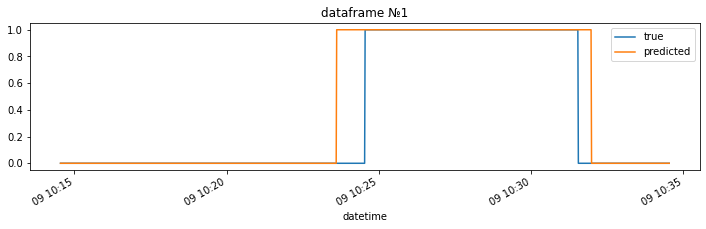

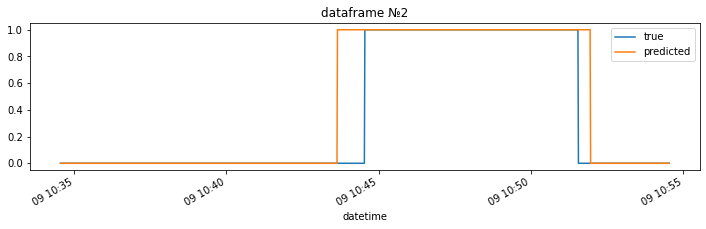

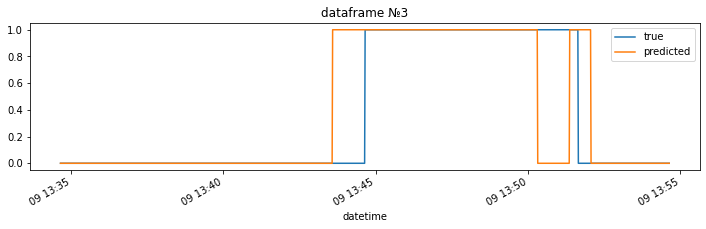

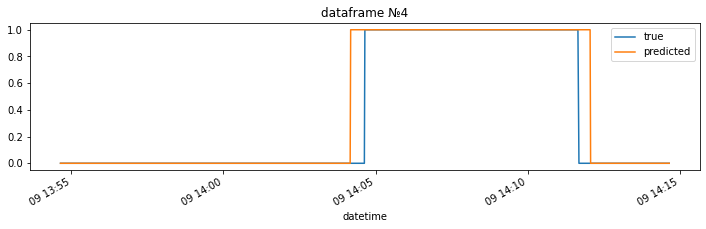

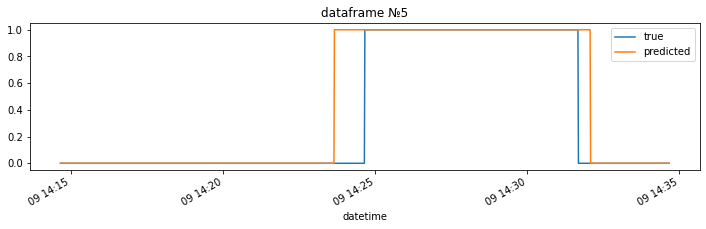

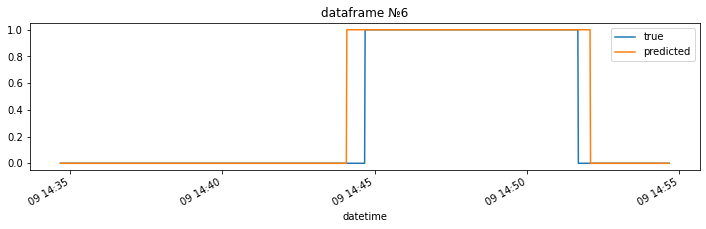

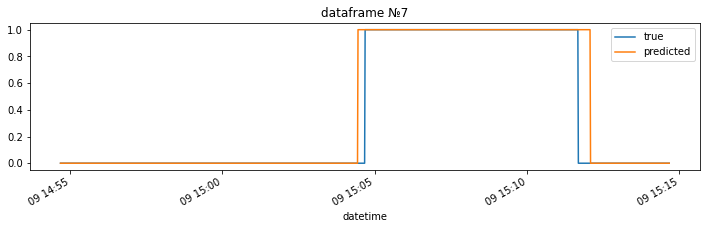

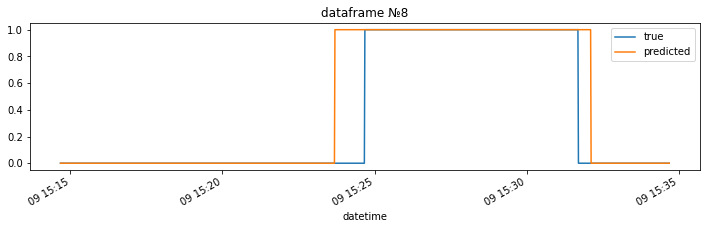

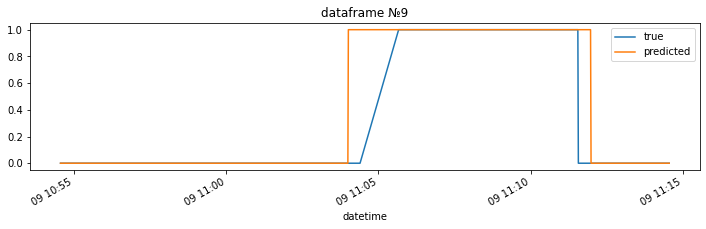

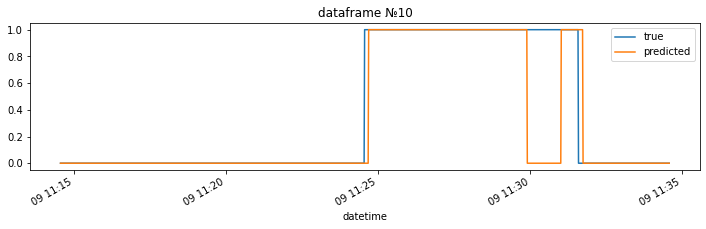

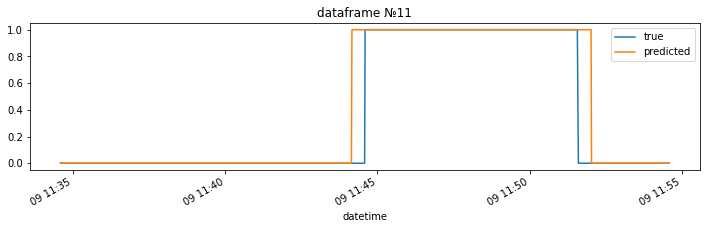

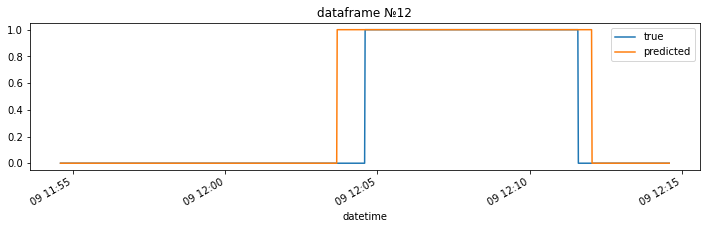

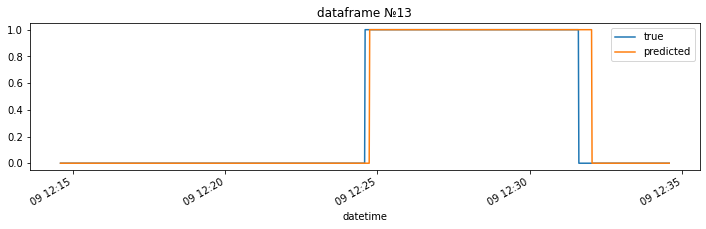

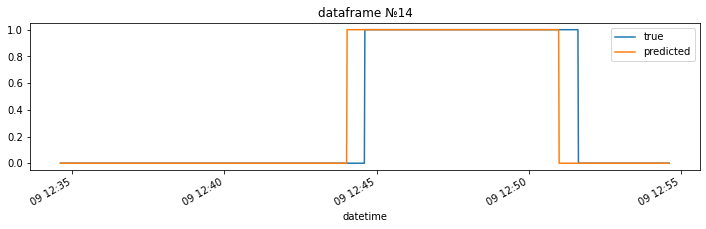

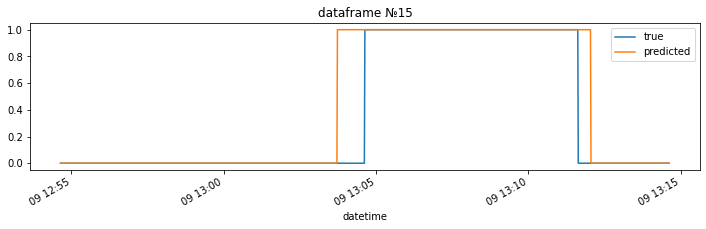

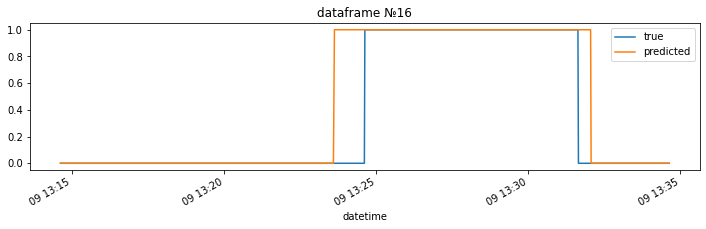

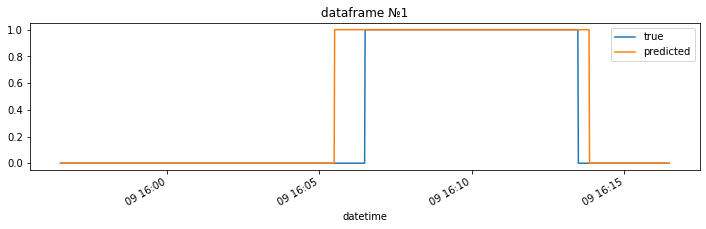

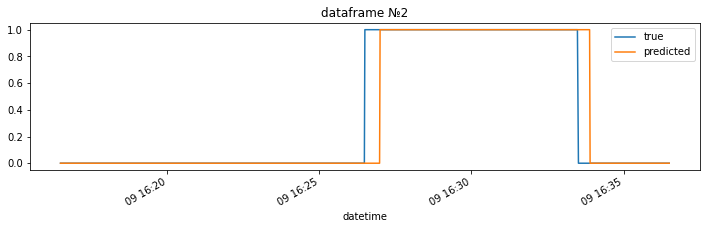

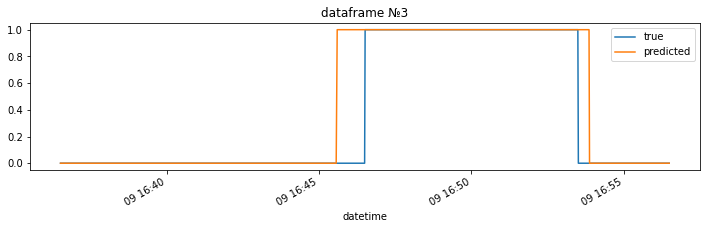

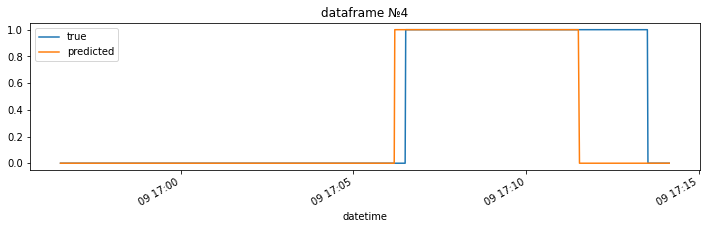

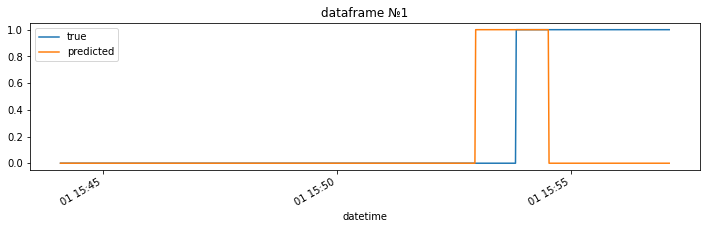

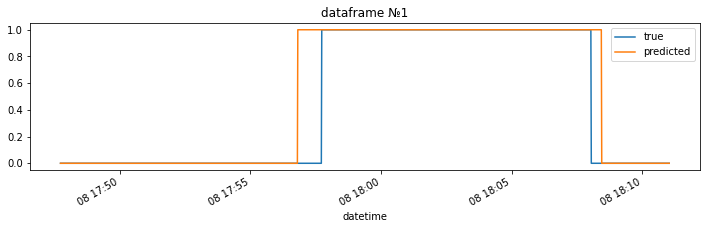

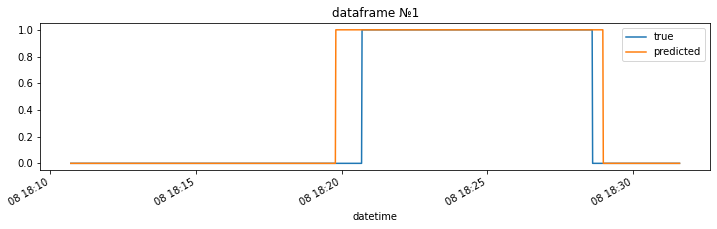

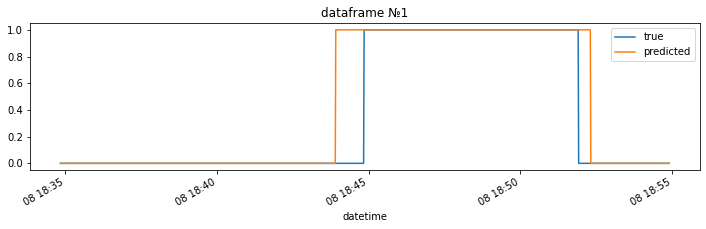

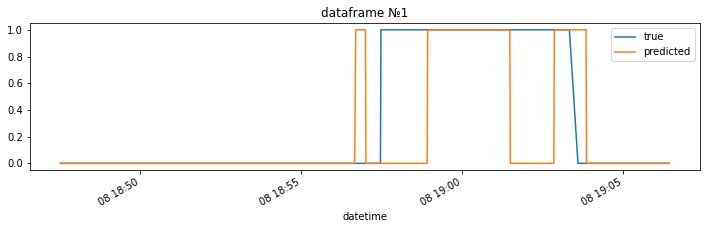

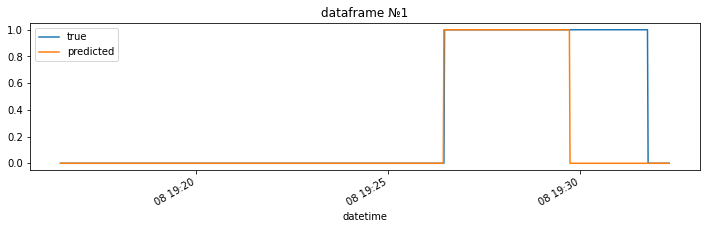

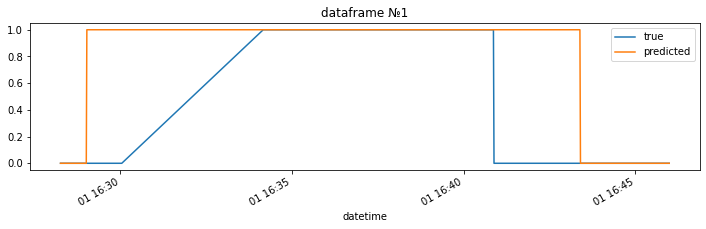

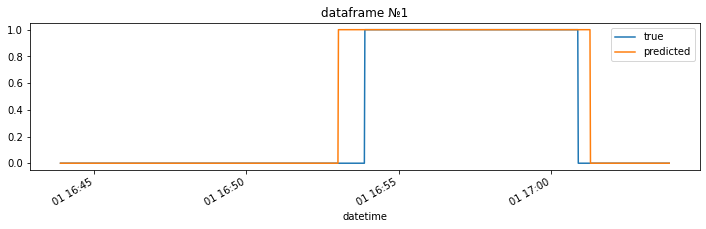

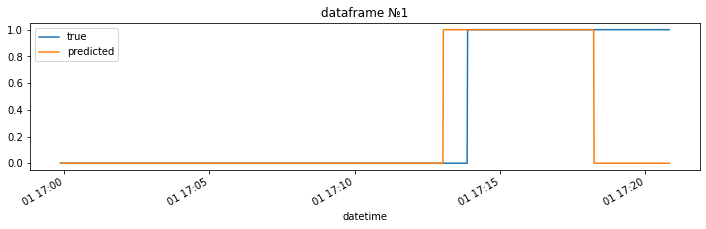

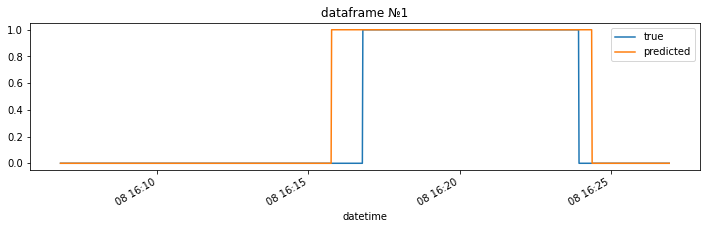

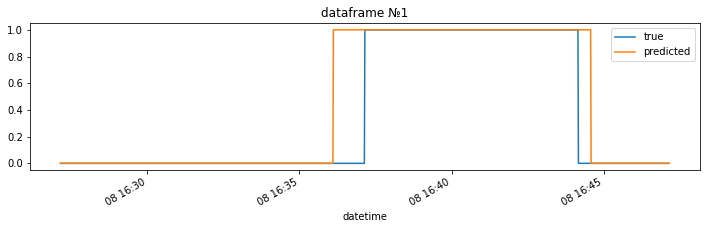

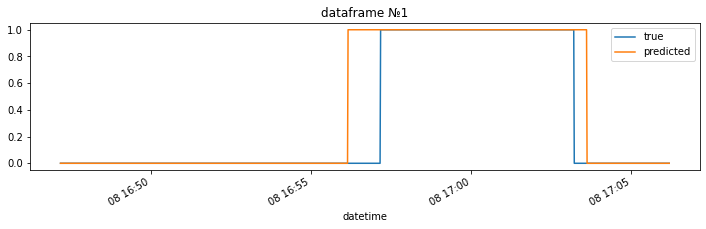

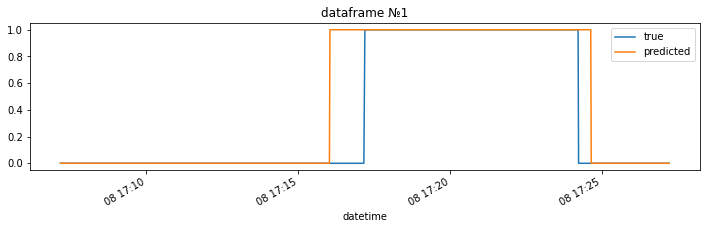

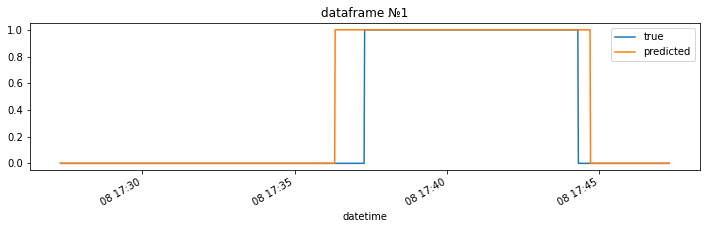

In [9]:
%%time
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = LSTM_AE_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [10]:
from utils.metrics import f1_score, far, mar

pred_outlier = pd.concat([pd.concat(p.all_predictions[i]) 
                          for i in range(len(p.all_predictions))])

list_of_all_df = []
for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            list_of_all_df.append(pd.concat([df.anomaly for df in [df, ]]))
    else:
        list_of_all_df.append(pd.concat([df.anomaly for df in list_of_df]))

true_outlier = pd.concat(list_of_all_df)

f1 = f1_score(true_outlier, pred_outlier)
far_score = far(true_outlier, pred_outlier)
mar_score = mar(true_outlier, pred_outlier)

metrics["all"] = (f1, far_score, mar_score)

In [11]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.92 | 0.89 | 0.29 | 0.94 | 0.93 | 0.89 | 0.68 | 0.76 | 0.79 | 0.92 | 0.72 | 0.91 | 0.91 | 0.9 | 0.9 | 0.91 | 0.89
FAR |0.08 | 0.07 | 0.09 | 0.1 | 0.1 | 0.1 | 0.05 | 0.0 | 0.51 | 0.1 | 0.06 | 0.11 | 0.11 | 0.11 | 0.12 | 0.1 | 0.09
MAR |0.03 | 0.09 | 0.79 | 0.0 | 0.0 | 0.0 | 0.42 | 0.38 | 0.0 | 0.0 | 0.37 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.06